In [1]:
import pandas as pd
import scanpy as sc
import os
import numpy as np
import pickle
from sklearn.metrics.pairwise import cosine_similarity

/home/icb/dominik.klein/mambaforge/envs/cellflow/lib/python3.12/site-packages/optuna/study/_optimize.py:29: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from optuna import progress_bar as pbar_module
/home/icb/dominik.klein/mambaforge/envs/cellflow/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/dominik.klein/mambaforge/envs/cellflow/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/dominik.klein/mambaforge/envs/cellflow/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWa

In [2]:
output_dir = "/lustre/groups/ml01/workspace/ot_perturbation/figures/pbmc/data/donor_similarity_pred"

In [3]:
adata = sc.read_h5ad("/lustre/groups/ml01/workspace/ot_perturbation/data/pbmc/adata_hvg2000_LV.h5ad")

In [4]:
files = os.listdir("/lustre/groups/ml01/workspace/ot_perturbation/models/otfm/pbmc_new_donor")
files_80_cytokines = [el for el in files if el.endswith("81_preds.h5ad")]

In [5]:
test_cytokines = list(set([el.split("_")[2] for el in files_80_cytokines]))

In [6]:
test_cytokines 

['IL-32-beta',
 'BAFF',
 'OX40L',
 'CD27L',
 'FasL',
 'IFN-omega',
 'IFN-gamma',
 'IL-1Ra',
 'M-CSF',
 'ADSF']

In [7]:
unique_donors = adata.obs["donor"].unique()

In [8]:
donor_control_vecs = {}
for donor in unique_donors:
    donor_control_vecs[donor] = adata[(adata.obs["donor"]==donor) & (adata.obs["cytokine"]=="PBS")].X.mean(axis=0)

In [9]:
donor_cytokine_displacements = {}
for donor in unique_donors:
    donor_cytokine_displacements[donor] = {}
    for cytokine in test_cytokines:
        adata_files = [el for el in files_80_cytokines if ((f"{donor}_" in el) and (cytokine in el))]
        assert len(adata_files)==1
        adata_file = adata_files[0]
        adata_pred = sc.read_h5ad(os.path.join("/lustre/groups/ml01/workspace/ot_perturbation/models/otfm/pbmc_new_donor", adata_file))
        donor_cytokine_displacements[donor][cytokine] = np.asarray(adata_pred.layers["X_recon"].mean(axis=0) -donor_control_vecs[donor])
    

In [10]:
with open("/lustre/groups/ml01/workspace/ot_perturbation/data/pbmc/donor_order.pkl", "rb") as file:
    donor_order = pickle.load(file)

In [11]:
df_donor_sim_pred = pd.DataFrame(index=donor_order, columns=donor_order)
for donor1 in donor_order:
    for donor2 in donor_order:
        repr_d1 = np.concatenate([donor_cytokine_displacements[donor1][cytokine] for cytokine in test_cytokines], axis=1)
        repr_d2 = np.concatenate([donor_cytokine_displacements[donor2][cytokine] for cytokine in test_cytokines], axis=1)
        df_donor_sim_pred.loc[donor1, donor2] = cosine_similarity(np.asarray(repr_d1), np.asarray(repr_d2))[0][0]


df_donor_sim_pred = df_donor_sim_pred.astype("float")

In [12]:
with open("/lustre/groups/ml01/workspace/ot_perturbation/data/pbmc/donor_cytokine_displacements.pkl", "rb") as file:
    donor_cytokine_displacements_true = pickle.load(file)
df_donor_sim_true = pd.DataFrame(index=donor_order, columns=donor_order)
for donor1 in donor_order:
    for donor2 in donor_order:
        repr_d1 = np.concatenate([donor_cytokine_displacements_true[donor1][cytokine] for cytokine in test_cytokines], axis=1)
        repr_d2 = np.concatenate([donor_cytokine_displacements_true[donor2][cytokine] for cytokine in test_cytokines], axis=1)
        df_donor_sim_true.loc[donor1, donor2] = cosine_similarity(np.asarray(repr_d1), np.asarray(repr_d2))[0][0]


df_donor_sim_true = df_donor_sim_true.astype("float")

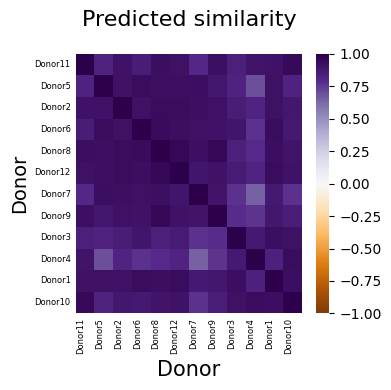

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size and style
plt.figure(figsize=(4, 4))  # Adjust width and height as needed

# Create the heatmap
sns.heatmap(
    df_donor_sim_pred.loc[donor_order, donor_order].astype("float"),
    cmap="PuOr",
    vmin=-1,
    vmax=1,
    xticklabels=True,  # Ensure all x-axis labels are shown
    yticklabels=True,  # Ensure all y-axis labels are shown
    
)

# Add titles and labels
plt.title("Predicted similarity", fontsize=16, pad=20)
plt.xlabel("Donor", fontsize=15)
plt.ylabel("Donor", fontsize=14)

# Adjust tick label size
plt.xticks(fontsize=6, rotation=90, ha="right")  # Rotate for better readability
plt.yticks(fontsize=6)
plt.tick_params(axis='x', which='both', length=0)  # Removes x-axis ticks but keeps labels
plt.tick_params(axis='y', which='both', length=0)  # Removes x-axis ticks but keeps labels

plt.savefig(os.path.join(output_dir, "donor_similarity_pred.pdf"), format="pdf", bbox_inches="tight")

plt.tight_layout() 
plt.show()


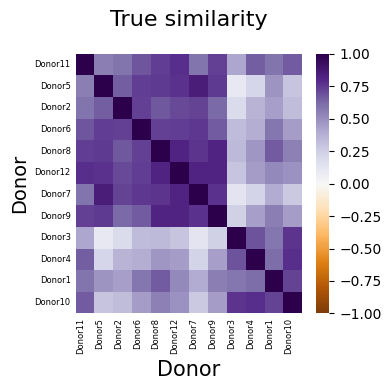

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size and style
plt.figure(figsize=(4, 4))  # Adjust width and height as needed

# Create the heatmap
sns.heatmap(
    df_donor_sim_true.loc[donor_order, donor_order].astype("float"),
    cmap="PuOr",
    vmin=-1,
    vmax=1,
    xticklabels=True,  # Ensure all x-axis labels are shown
    yticklabels=True,  # Ensure all y-axis labels are shown
    
)

# Add titles and labels
plt.title("True similarity", fontsize=16, pad=20)
plt.xlabel("Donor", fontsize=15)
plt.ylabel("Donor", fontsize=14)

# Adjust tick label size
plt.xticks(fontsize=6, rotation=90, ha="right")  # Rotate for better readability
plt.yticks(fontsize=6)
plt.tick_params(axis='x', which='both', length=0)  # Removes x-axis ticks but keeps labels
plt.tick_params(axis='y', which='both', length=0)  # Removes x-axis ticks but keeps labels

plt.savefig(os.path.join(output_dir, "donor_similarity_true.pdf"), format="pdf", bbox_inches="tight")

plt.tight_layout() 
plt.show()


In [15]:

df_donor_sim_preds = {}
for cytokine in test_cytokines:
    df_donor_sim_pred = pd.DataFrame(index=donor_order, columns=donor_order)
    for donor1 in donor_order:
        for donor2 in donor_order:
            repr_d1 = donor_cytokine_displacements[donor1][cytokine]
            repr_d2 = donor_cytokine_displacements[donor2][cytokine]
            df_donor_sim_pred.loc[donor1, donor2] = cosine_similarity(np.asarray(repr_d1), np.asarray(repr_d2))[0][0]
            df_donor_sim_preds[cytokine] = df_donor_sim_pred.astype("float")


In [16]:

df_donor_sim_trues = {}
for cytokine in test_cytokines:
    df_donor_sim_true = pd.DataFrame(index=donor_order, columns=donor_order)
    for donor1 in donor_order:
        for donor2 in donor_order:
            repr_d1 = donor_cytokine_displacements_true[donor1][cytokine]
            repr_d2 = donor_cytokine_displacements_true[donor2][cytokine]
            df_donor_sim_true.loc[donor1, donor2] = cosine_similarity(np.asarray(repr_d1), np.asarray(repr_d2))[0][0]
            df_donor_sim_trues[cytokine] = df_donor_sim_true.astype("float")


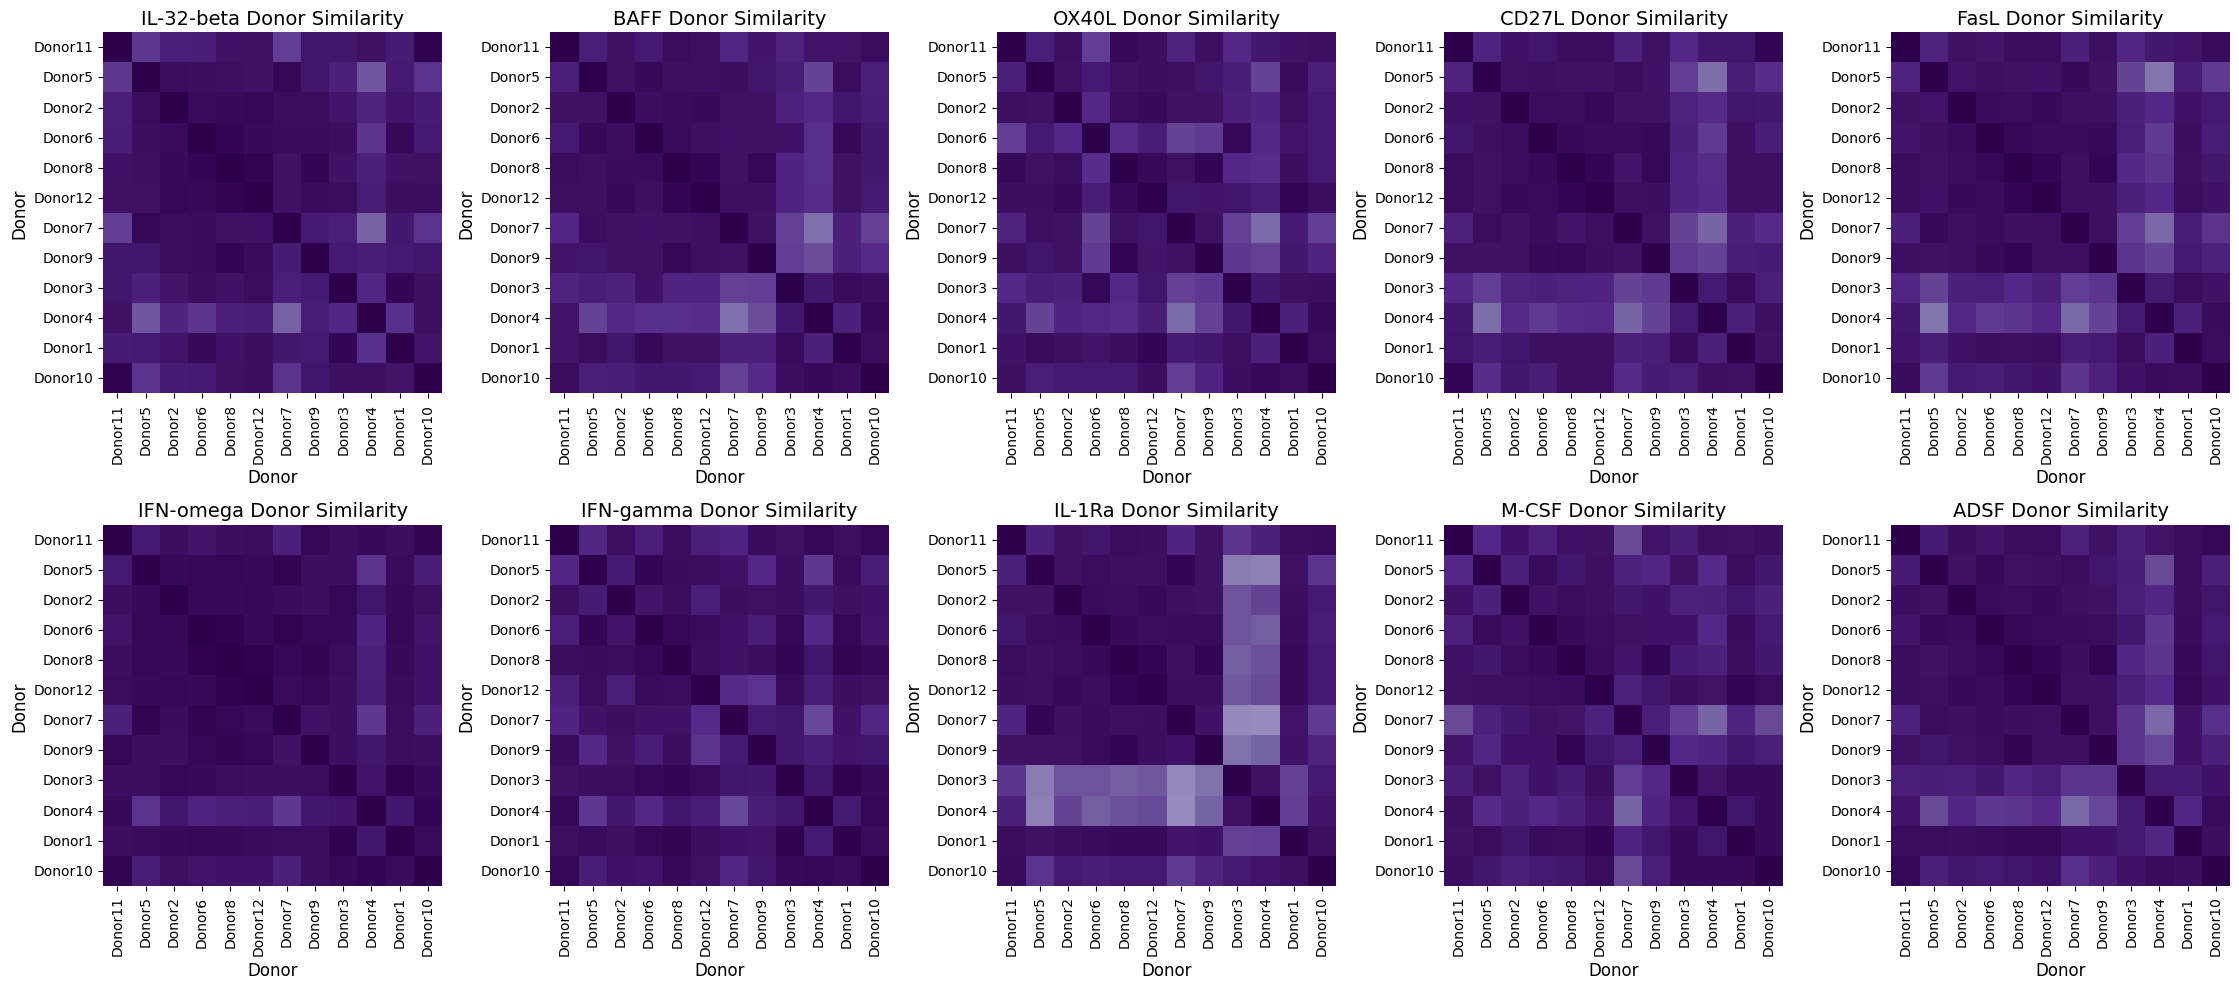

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 5, figsize=(25, 10))  # 2 rows, 5 columns
axes = axes.flatten()  # Flatten to easily iterate

for i, cytokine in enumerate(test_cytokines):
    ax = axes[i]
    sns.heatmap(
        df_donor_sim_preds[cytokine].loc[donor_order, donor_order],
        cmap="PuOr",
        vmin=-1,
        vmax=1,
        xticklabels=True,
        yticklabels=True,
        ax=ax,
        cbar=False  # Optional: turn off individual colorbars
    )
    ax.set_title(f"{cytokine} Donor Similarity", fontsize=14)
    ax.set_xlabel("Donor", fontsize=12)
    ax.set_ylabel("Donor", fontsize=12)

# Optional: Add a single colorbar to the side
cbar_ax = fig.add_axes([0.92, 0.3, 0.015, 0.4])  # [left, bottom, width, height]
sns.heatmap(
    df_donor_sim_preds[test_cytokines[0]].loc[donor_order, donor_order],
    cmap="PuOr",
    vmin=-1,
    vmax=1,
    cbar_ax=cbar_ax,
    cbar=True,
    xticklabels=False,
    yticklabels=False
).remove()  # Don't actually show the heatmap again, just use for the colorbar

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Make room for colorbar
plt.show()


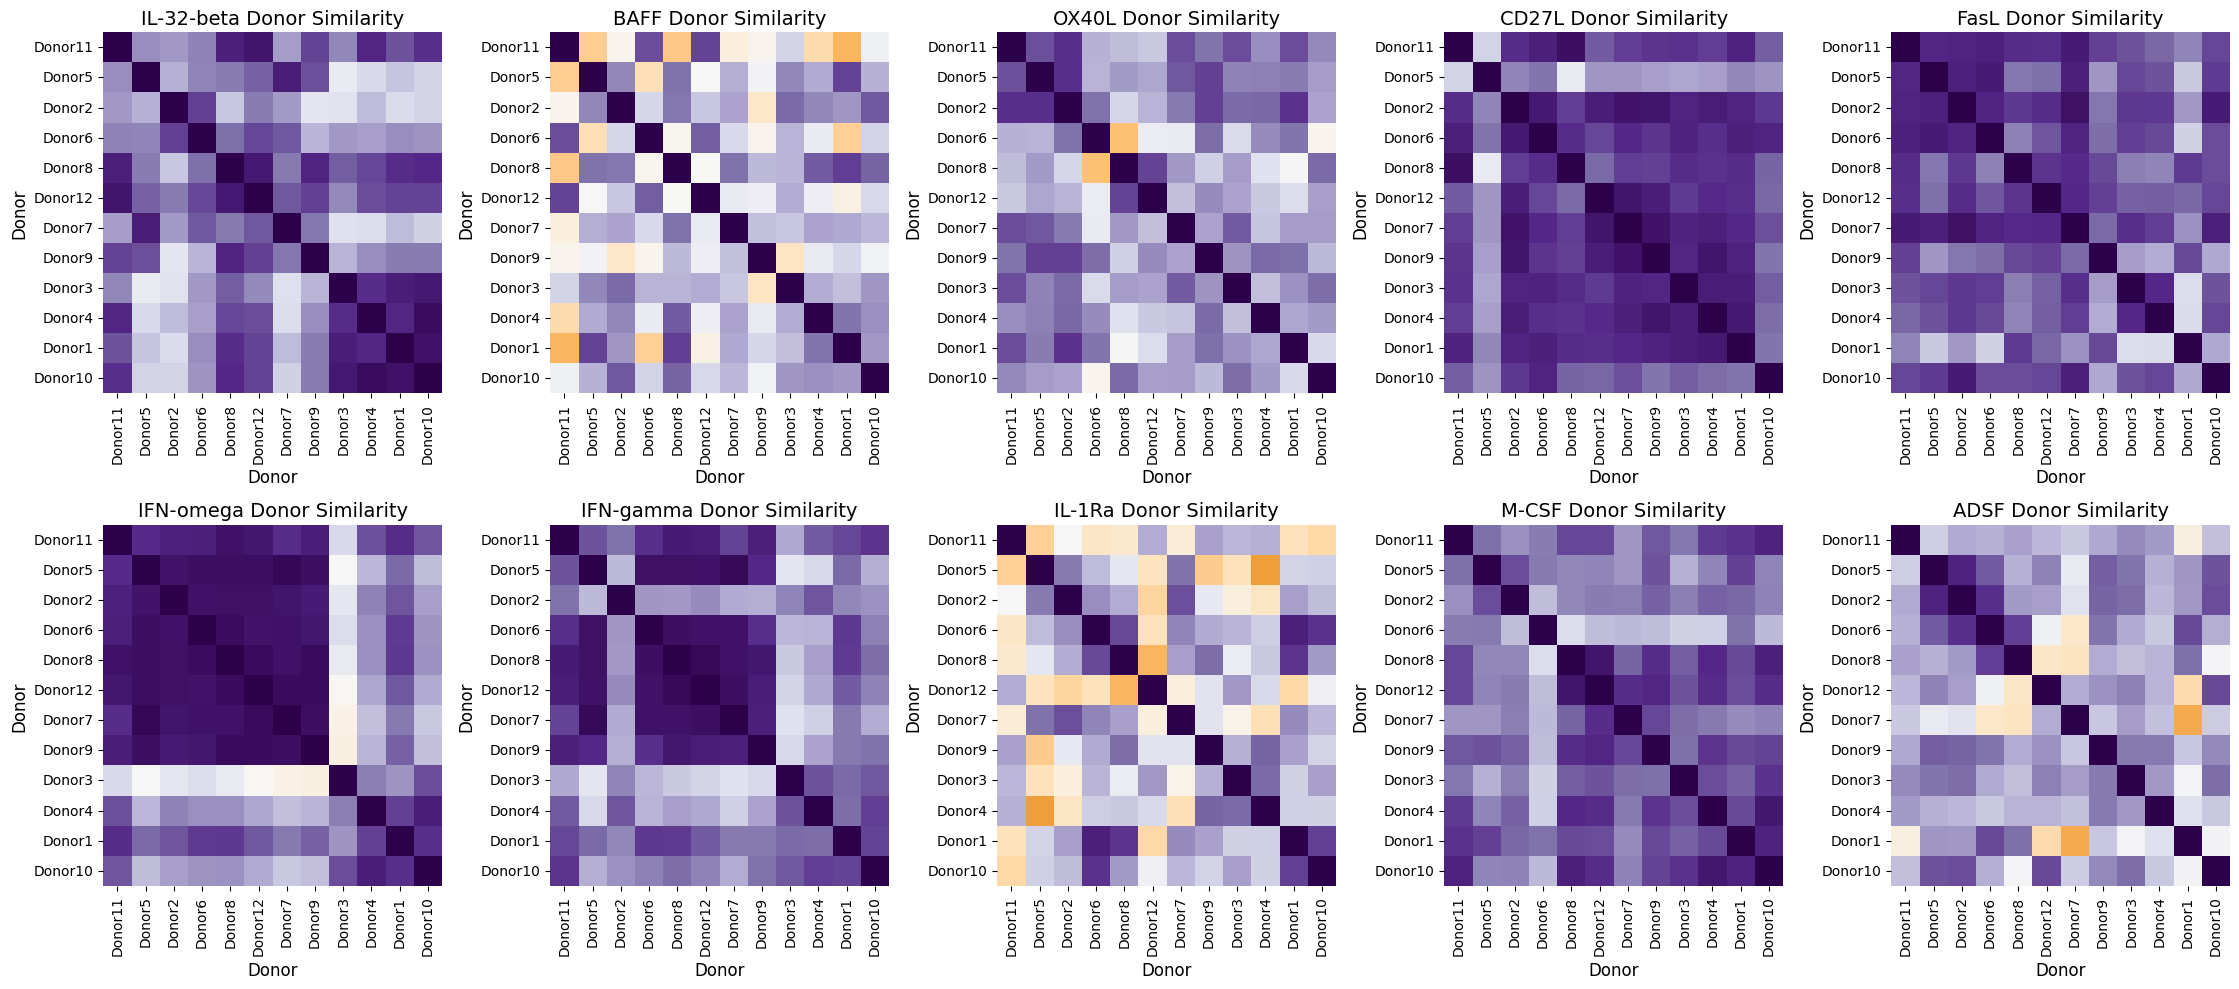

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 5, figsize=(25, 10))  # 2 rows, 5 columns
axes = axes.flatten()  # Flatten to easily iterate

for i, cytokine in enumerate(test_cytokines):
    ax = axes[i]
    sns.heatmap(
        df_donor_sim_trues[cytokine].loc[donor_order, donor_order],
        cmap="PuOr",
        vmin=-1,
        vmax=1,
        xticklabels=True,
        yticklabels=True,
        ax=ax,
        cbar=False  # Optional: turn off individual colorbars
    )
    ax.set_title(f"{cytokine} Donor Similarity", fontsize=14)
    ax.set_xlabel("Donor", fontsize=12)
    ax.set_ylabel("Donor", fontsize=12)

# Optional: Add a single colorbar to the side
cbar_ax = fig.add_axes([0.92, 0.3, 0.015, 0.4])  # [left, bottom, width, height]
sns.heatmap(
    df_donor_sim_trues[test_cytokines[0]].loc[donor_order, donor_order],
    cmap="PuOr",
    vmin=-1,
    vmax=1,
    cbar_ax=cbar_ax,
    cbar=True,
    xticklabels=False,
    yticklabels=False
).remove()  # Don't actually show the heatmap again, just use for the colorbar

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Make room for colorbar
plt.show()


In [19]:
df_sims = pd.DataFrame(index=donor_order, columns=test_cytokines)
pearson_corrs = []
spearman_corrs = []
for cyto in test_cytokines:
    for donor in donor_order:
        df_sims.loc[donor, cyto] = np.corrcoef(df_donor_sim_preds[cyto].loc[donor], df_donor_sim_trues[cyto].loc[donor])[0,1]

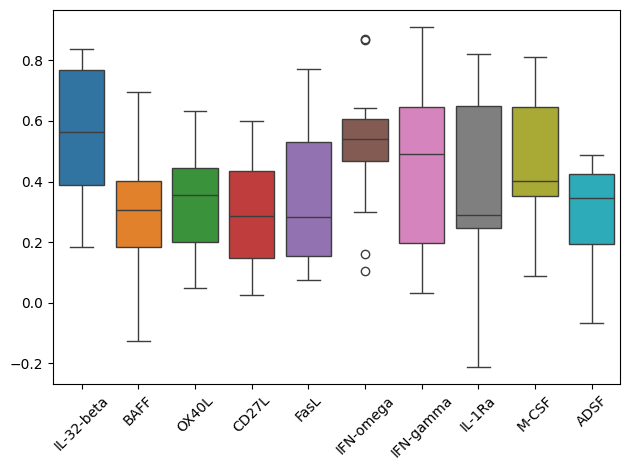

In [20]:
sns.boxplot(data=df_sims)
plt.xticks(rotation=45)  # or any angle you prefer
plt.tight_layout()  # optional: ensures labels don't get cut off
plt.show()

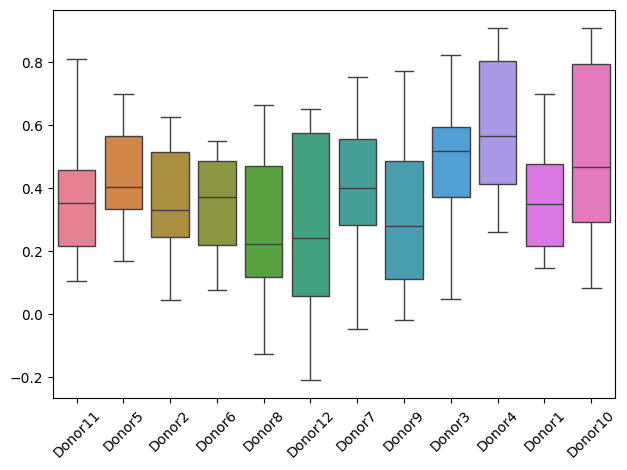

In [21]:
sns.boxplot(data=df_sims.T)
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()

In [22]:
df_sims_1 = df_sims.copy()
df_sims_1 = pd.melt(df_sims_1, value_name="e_distance")
df_sims_1.to_csv("/lustre/groups/ml01/workspace/ot_perturbation/data/pbmc/results/allocation/similarity_correlations_per_cytokine.csv")

In [23]:
df_sims_2 = df_sims.T
df_sims_2 = pd.melt(df_sims_2, value_name="e_distance")

In [24]:
df_sims_2.to_csv("/lustre/groups/ml01/workspace/ot_perturbation/data/pbmc/results/allocation/similarity_correlations_per_donor.csv")

In [25]:
donor_order

Index(['Donor11', 'Donor5', 'Donor2', 'Donor6', 'Donor8', 'Donor12', 'Donor7',
       'Donor9', 'Donor3', 'Donor4', 'Donor1', 'Donor10'],
      dtype='object')